In [22]:
import pandas as pd
import io
import requests
import string
import random

import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_sequence, pack_padded_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
from pytorch_lightning.callbacks.progress import TQDMProgressBar, RichProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl


In this tutorial you'll look at building an encoder and a decoder from scratch. Specifically you'll be learning how to generate names. Generating names requires an understanding of what's in a name which is where the encoder comes in. The encoder for us will look at forming a probability distribution over characters. The decoder can then begin generating characters based on what was learned from the encoder.

In [23]:
# First download a list of baby names
url = 'https://raw.githubusercontent.com/hadley/data-baby-names/master/baby-names.csv'
content = requests.get(url).content
df = pd.read_csv(io.StringIO(content.decode('utf-8')))
df.head()

,year,name,percent,sex
0,1880,John,0.081541,boy
1,1880,William,0.080511,boy
2,1880,James,0.050057,boy
3,1880,Charles,0.045167,boy
4,1880,George,0.043292,boy


In [24]:
df = df[['name', 'sex']].drop_duplicates().reset_index(drop=True)
df.head()

,name,sex
0,John,boy
1,William,boy
2,James,boy
3,Charles,boy
4,George,boy


In [25]:
print(df['sex'].value_counts())


girl    4018
boy     3437
Name: sex, dtype: int64


In [26]:
longest_boy_idx = df[df['sex']=='boy']['name'].str.len().idxmax()
shortest_boy_idx = df[df['sex']=='boy']['name'].str.len().idxmin()
longest_girl_idx = df[df['sex']=='girl']['name'].str.len().idxmax()
shortest_girl_idx = df[df['sex']=='girl']['name'].str.len().idxmin()

print(f'longest boy name: {df["name"].iloc[longest_boy_idx]}')
print(f'shortest boy name: {df["name"].iloc[shortest_boy_idx]}')
print(f'longest girl name: {df["name"].iloc[longest_girl_idx]}')
print(f'shortest girl name: {df["name"].iloc[shortest_girl_idx]}')

longest boy name: Christopher
shortest boy name: Ed
longest girl name: Margueritta
shortest girl name: Jo


Next create a mapping for character -> idx and idx -> character

In [27]:
chars = ['<pad>'] + ['<sos>'] + list(string.ascii_lowercase) + ['<eos>']
n_chars = len(chars)
char2idx = {char: idx for idx,char in enumerate(chars)}
idx2char = {idx: char for char,idx in char2idx.items()}

print(char2idx['<pad>'])
print(idx2char[0])

print(char2idx['a'])

0
<pad>
2


We can now create a one-hot vector to represent the character.

In [28]:
def char_to_tensor(char: str) -> torch.Tensor:
    """
    Take a character and perform a one-hot encoding in the form of a tensor
    """
    ret = torch.zeros(1, n_chars)
    ret[0][char2idx[char]] = 1
    return ret

char_to_tensor('c')


tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [29]:
def name_to_tensor(name: str, insert_toks: bool=False, max_len: int=None) -> torch.Tensor:
    if insert_toks:
        # Add the <sos> and <eos> tokens
        ret = torch.zeros(len(name) + 2, 1, n_chars)
        name = ['<sos>'] + list(name) + ['<eos>']
    else:
        ret = torch.zeros(len(name), 1, n_chars)
        name = list(name)
    
    # If there is a max_len set, pad to it
    if max_len is not None:
        ret = torch.zeros(max_len, 1, n_chars)
        name = name + ['<pad>']*(max_len - len(name))

    for i, char in enumerate(name):
        ret[i] = char_to_tensor(char)
    return ret

name_tensor = name_to_tensor('ab', insert_toks=True)
print(name_tensor)
print(name_tensor.shape)

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])
torch.Size([4, 1, 29])


Next we can tokenize the names and insert the beginning and end token as well.

In [30]:
def get_tokenized_names(df: pd.DataFrame):
    names = df['name']
    ret = []
    for name in names:
        arr = ['<sos>'] + list(name.lower()) + ['<eos>']
        ret.append(arr)
    return ret

tokenized_names = get_tokenized_names(df)
max_len = max(len(name) for name in tokenized_names)
max_len

13

Split into a train/val/test set.

In [31]:
random.seed(0xC0FFEE)

def get_train_val_test(tokenized_names, train_percent, val_percent, test_percent):    
    names = random.sample(tokenized_names, len(tokenized_names))
    num_train = int(len(names) * train_percent)
    num_val = int(len(names) * val_percent)

    train_names = names[0:num_train]
    val_names = names[num_train:num_train + num_val]
    test_names = names[num_train + num_val:]

    return train_names, val_names, test_names

train, val, test = get_train_val_test(tokenized_names, 0.85, 0.10, 0.05)


Next we can pad out the data to fixed length for our encoder and create a training pair of `(window, next_char)`.

In [32]:
def samples_to_padded_sequences(samples: list[list[str]]):
    padded = []
    # Each sample is a name
    for sample in samples:
        # Make the sliding window
        for idx in range(len(sample) - 1):
            window = sample[:idx + 1]
            next_char = sample[idx + 1]
            padding = ['<pad>'] * (max_len - len(window))
            padded_seq = window + padding
            xy = [padded_seq, next_char]
            padded.append(xy)
    return padded

def padded_sequence_to_one_hot(padded_seq: list[tuple[list[int], int]]):
    x, y = [], []
    for ps in padded_seq:
        window = ps[0]
        next_char = ps[1]
        
        ret_window = torch.cat([char_to_tensor(char) for char in window]).unsqueeze(0)
        ret_char = char2idx[next_char]
        x.append(ret_window)
        y.append(ret_char)
    return (torch.cat(x), torch.tensor(y).reshape(-1, 1))


Here's an example of the first 10 entries in the training set. Notice these are a sliding window over the name `antonette`. 

In [33]:
rt = samples_to_padded_sequences(train)
for e in rt[:10]:
    print(e)

[['<sos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 'a']
[['<sos>', 'a', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 'n']
[['<sos>', 'a', 'n', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 't']
[['<sos>', 'a', 'n', 't', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 'o']
[['<sos>', 'a', 'n', 't', 'o', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 'n']
[['<sos>', 'a', 'n', 't', 'o', 'n', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 'e']
[['<sos>', 'a', 'n', 't', 'o', 'n', 'e', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 't']
[['<sos>', 'a', 'n', 't', 'o', 'n', 'e', 't', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], 't']
[['<sos>', 'a', 'n', 't', 'o', 'n', 'e', 't', 't', '<pad>', '<pad>', '<pad>', '<pad>'], 'e']
[['<sos>', 'a', 'n'

In [34]:
train_x, train_y = padded_sequence_to_one_hot(samples_to_padded_sequences(train))
val_x, val_y = padded_sequence_to_one_hot(samples_to_padded_sequences(val))
test_x, test_y = padded_sequence_to_one_hot(samples_to_padded_sequences(test))

print('train shape', train_x.shape)
print('val shape', val_x.shape)
print('test shape', test_x.shape)


train shape torch.Size([43626, 13, 29])
val shape torch.Size([5150, 13, 29])
test shape torch.Size([2618, 13, 29])


In [35]:
def get_dataloader(x, y, batch_size: int, shuffle: bool):
    dataset = TensorDataset(x, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = get_dataloader(train_x, train_y, 1024, True)
val_dataloader   = get_dataloader(val_x, val_y, 256, False)
test_dataloader  = get_dataloader(test_x, test_y, 128, False)

We're going to use our model to predict one character at a time. Given some partial sequence of characters, predict the next one. Take for example the name "Alex". This will become<br>
`['<sos>', 'a', 'l', 'e', 'x', '<eos>']`

But when we train the model we're training on partial sequences to predict the next character like so:

| i | input (partial seq)                 | output (next char) |
|---|-------------------------------------|--------------------|
| 0 | ['\<sos>']                          |  'a'               |
| 1 | ['\<sos>', 'a']                     |  'l'               |
| 2 | ['\<sos>', 'a', 'l']                |  'e'               |
| 3 | ['\<sos>', 'a', 'l', 'e']           |  'x'               |
| 4 | ['\<sos>', 'a', ''l', 'e', 'x']     |  '\<eos>'          |

The purpose of this is to learn the weights and ultimately a good representation of a name.

In [36]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int = 1,
                dropout: float = 0.0):
        super().__init__()

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, output_size)
    
    def forward(self, seqs):
        # [len, batch, n_chars]
        _, h_n = self.rnn(seqs)
        hidden_states = torch.cat((h_n[0], h_n[1]), dim=1)
        return self.fc(hidden_states)

In [37]:
encoder = RNNEncoder(n_chars, 128, n_chars)
single_batch = train_x[0].unsqueeze(1)
print('shape', single_batch.shape)
encoder(single_batch)


shape torch.Size([13, 1, 29])


tensor([[-0.0417, -0.0423, -0.0734, -0.0599, -0.0539,  0.0248,  0.0660, -0.0188,
         -0.0803,  0.1022, -0.0965, -0.0967, -0.0425,  0.0490, -0.0951, -0.0396,
         -0.0502,  0.1231, -0.1715, -0.1591, -0.0556,  0.0816, -0.1551,  0.0567,
         -0.0513,  0.0775, -0.0314,  0.0020,  0.0731]],
       grad_fn=<AddmmBackward0>)

In [38]:
class LitModel(pl.LightningModule):
    def __init__(self, encoder: nn.Module, device='cuda'):
        super().__init__()
        self._device=device
        self.encoder = encoder
    
    def _generic_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(1, 0, 2)
        out = self.encoder(x)
        loss = F.cross_entropy(out, y.squeeze(1))
        return loss
    
    def forward(self, seq):
        return self.encoder(seq.to(self._device))

    def training_step(self, batch, batch_idx):
        return self._generic_step(batch, batch_idx)
    
    def validation_step(self, batch, batch_idx):
        loss = self._generic_step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.encoder.parameters(), lr=2e-3)
        return opt

device='cuda' if torch.cuda.is_available() else 'cpu'
print('device is', device)
# device = 'cpu'


device is cuda


In [39]:
rnn_encoder = RNNEncoder(n_chars, 128, n_chars, num_layers=2).to(device)
rnn_lit_model = LitModel(rnn_encoder)
rnn_trainer = pl.Trainer(accelerator=device, max_epochs=100, log_every_n_steps=25,
                     callbacks=[
                        RichProgressBar(refresh_rate=50),
                        EarlyStopping(monitor='val_loss', mode='min', patience=3)
                     ])
rnn_trainer.fit(rnn_lit_model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder │ RNNEncoder │  146 K │
└───┴─────────┴────────────┴────────┘

Trainable params: 146 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 146 K                                                                                                
Total estimated model params size (MB): 0

Output()

/opt/anaconda/v3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: 
PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) 
in the `DataLoader` init to improve performance.
  rank_zero_warn(

/opt/anaconda/v3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: 
PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) 
in the `DataLoader` init to improve performance.
  rank_zero_warn(

At this point the model has trained on quite a few names and has hopefully learned a bit about names. We can test this by seeing what letter the model thinks should come next for some sequence. Let's test this with the name `ryan`. I'm choosing this name because the dataset the names came from contains two names starting with `rya`. One is `ryan` and the other is `ryann`. So we can use it to see how confident the model is that the next letter should be `n`.

In [75]:
def pad_partial_name(partial_name: str, max_len: int):
    partial_seq = ['<sos>'] + list(partial_name)
    ret = torch.zeros(max_len, 1, n_chars)
    partial_seq = partial_seq + ['<pad>']*(max_len - len(partial_seq))

    for i, char in enumerate(partial_seq):
        ret[i] = char_to_tensor(char)
    return ret

def predict_next_letter(partial_name: str, encoder: nn.Module, n=1) -> tuple[str, float]:
    with torch.no_grad():
        encoder.train(False)
        name_tensor = pad_partial_name(partial_name, max_len)
        out = F.softmax(encoder(name_tensor), dim=-1)
        prob, idxs = torch.sort(out, descending=True)
        prob = prob.cpu().numpy().flatten()[:n]
        idxs = idxs.cpu().numpy().flatten()[:n]
        # idxs = torch.argsort(out).cpu().numpy()[:n]
        next_char = [idx2char[idx] for idx in idxs]
        encoder.train(True)
    return (next_char, prob)

predict_next_letter('rya', rnn_lit_model.encoder)

(['n'], array([0.28105763], dtype=float32))

That worked pretty well. It thinks the most likely next letter is `n` with 28% probability. Next let's see how this compares to an LSTM.

In [41]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int = 1,
                dropout: float = 0.0):
        super().__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(2 * 2 * hidden_size * num_layers, output_size)
    
    def forward(self, seqs):
        # [len, batch, n_chars]
        # h_n is a tuple where each index is [2 * num_layers, batch, hidden_size]
        _, h_n = self.lstm(seqs)
        # Cat and permute. Cat will combine the tuple so it's [2 * num_layers, batch, hidden_size * 2]
        # and permute will get it so batch is first [batch, 2*num_layers, hidden_size*2]
        hidden_states = torch.cat((h_n[0], h_n[1]), dim=-1).permute(1, 0, 2)
        # Flatten starting at the first index so we get [batch, 2*num_layers*2*hidden_size]
        out = torch.flatten(hidden_states, start_dim=1)
        return self.fc(out)

In [42]:
encoder = LSTMEncoder(n_chars, 128, n_chars, num_layers=2)
single_batch = train_x[0].unsqueeze(1)
print('shape', single_batch.shape)
encoder(single_batch)

shape torch.Size([13, 1, 29])


tensor([[-0.0374,  0.0276,  0.0176,  0.0163,  0.0482, -0.0196, -0.0117,  0.0373,
         -0.0335,  0.0311, -0.0508,  0.1083,  0.0243, -0.0579,  0.1008, -0.0215,
         -0.0121, -0.0022, -0.0254,  0.0409, -0.0068, -0.0018, -0.1024,  0.0061,
         -0.0293,  0.0791,  0.0374,  0.0848, -0.0277]],
       grad_fn=<AddmmBackward0>)

In [43]:
lstm_encoder = LSTMEncoder(n_chars, 128, n_chars, num_layers=2).to(device)
lstm_lit_model = LitModel(lstm_encoder)
lstm_trainer = pl.Trainer(accelerator=device, max_epochs=100, log_every_n_steps=25,
                     callbacks=[
                        RichProgressBar(refresh_rate=50),
                        EarlyStopping(monitor='val_loss', mode='min', patience=3)
                     ])
lstm_trainer.fit(lstm_lit_model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder │ LSTMEncoder │  587 K │
└───┴─────────┴─────────────┴────────┘

Trainable params: 587 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 587 K                                                                                                
Total estimated model params size (MB): 2

Output()

Now let's look at how the LSTM model compares when looking at the next letter for `rya`.

In [76]:
predict_next_letter('rya', lstm_lit_model.encoder)


(['n'], array([0.8853272], dtype=float32))

Try out some different architectures and see if you can reduce the loss. You can try adding dropout, an additional layer after the final hidden state, etc. You can also try reducing the learning rate over time. Now let's look at generating a name based on the model we trained. This is going to be done by using a decoder. Let's start with a greedy decoder.

In [67]:
import math

def greedy_decoder(encoder: nn.Module, max_len: int, partial_name=''):
    ret = partial_name
    curr_len = len(ret)
    curr_tok = None
    total_prob = 0
    
    while curr_tok != '<eos>' and curr_len < max_len:
        curr_tok, prob = predict_next_letter(ret, encoder)
        total_prob += math.log(prob)
        if curr_tok != '<eos>':
            ret += curr_tok
    return ret, math.exp(total_prob)

greedy_decoder(lstm_lit_model.encoder, max_len)

('alexandre', 0.00016087609665491233)

So what does this mean? Does it mean that `alexandre` is the most probable name? No.
This greedy decoder is a character level greedy decoder. This means that at each step it picks the most likely next character, e.g.

 1\. max `p(c | ['<sos>'])` = `a`
 
 2\. max `p(c | ['<sos>', 'a'])` = `l`
<br>
...

 10\. max `p(c | ['<sos>', 'a', 'l', 'e', 'x', 'a', 'n', 'd', 'r', 'e'])` = `'<eos>'`

What we're generally looking for when decoding is the sequence that produces the highest probability. This probability might not be represented by the greedy decoder. Take for example this 2 sequence example:

| sequence | probs  | overall prob  |
|----------|--------|-------------- |
| ['s', 'b', 'c'] | .3, .2, .2 | .012 |
| ['a', 'b', 'c'] | .2, .8, .9 | .144 |

Because in this example 's' has a higher probability of being selected, the greedy decoder would go down that path and choose `sbc` even though the overall probability of `abc` is higher. Okay great. So all we need to do is go down every path and just find the sequence that produces the highest probability. While that'd be awesome, even with this small example of 29 characters you would need to go over ~$29^{13}$ different examples. Because of this we need a better way to find a most probable output. Next let's look at a beam decoder. The beam decoder takes a beam of some size, k,  and tracks the most probable characters of that fixed width beam. Then at each step it takes each of the k candidate sequences and combines the next k most likely and finally pruned to the top k new sequence candidates. Below is what that looks like.

In [114]:

def beam_decoder(encoder: nn.Module, max_len: int, partial_name='', k=5):
    curr_len = len(partial_name)
    candidates = [(partial_name, 0, False)] # (seq, prob, done)
    
    # We automatically inject <sos> token so in this case we go max_len - 1
    for _ in range(max_len - curr_len - 1):
        potential_candidates = []

        for seq, prob, is_done in candidates:
            # Don't do anything if the candidate has hit <eos>
            if is_done:
                potential_candidates.append((seq, prob, is_done))
                continue

            next_toks, next_probs = predict_next_letter(seq, encoder, n=k)
            for next_tok, next_tok_prob in zip(next_toks, next_probs):
                newly_done = next_tok == '<eos>'
                log_prob = math.log(next_tok_prob)
                new_prob = prob + log_prob
                new_seq = seq
                if not newly_done:
                    new_seq += next_tok
                potential_candidates.append((new_seq, new_prob, newly_done))
        # Sort and grab the k most probable
        # How you sort is your choice. I'm choosing to initially sort by ones that are done, followed by highest probability
        # and finally followed by selecting shorter names
        candidates = sorted(potential_candidates, key=lambda x: (x[2], x[1], -len(x[0])), reverse=True)[:k]
        # break

    # Take all candidates and return the candidate with the exp of the prob
    seqs = [candidate[0] for candidate in candidates]
    probs = [math.exp(candidate[1]) for candidate in candidates]
    return seqs, probs

beam_decoder(lstm_lit_model.encoder, max_len, k=5)

(['alex', 'marge', 'jacque', 'alexa', 'jacqu'],
 [0.0003029634823899965,
  0.00018451205072100678,
  0.0001707193587972278,
  0.00016854112962335765,
  1.8486967055518538e-05])

In this case you can see that `alex` is actually more porbable than `alexandre` but because the greedy decoder saw `a` as a more likely candidate than `<eos>` it kept decoding. Another thing to notice here is that "jacqu" is not even in the dataset. The model learned a probability distribution and was able to determine that it could be a name. The fun thing is you can also precondition on certain characters/partial names like so:

In [118]:
beam_decoder(lstm_lit_model.encoder, max_len, k=5, partial_name='br')[0]

['brad', 'britt', 'brian', 'brand', 'bria']

Finally let's look at one more decoding scheme called nucleus decoding. With greedy decoding you take just the next most probable token. With beam search you take the k next probable and prune. With nucleus decoding the idea is that you take N tokens at each step until you hit some threshold percentage. The idea here is you will most likely have a long tailed distribution where a majority of the distribution is formed around a few tokens. Let's look at this in a concrete example. Consider the next letter to appear after a name starting with the letter 'a'. Take the next tokens and sort them by their probability and sample from it. Below is a quick example.

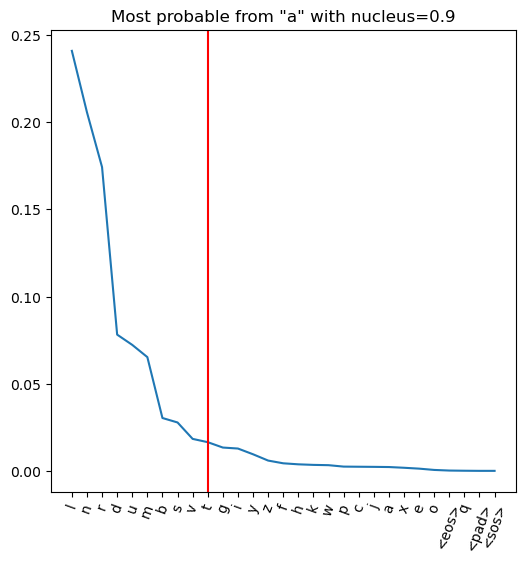

0.9132244
tokens needed ['l', 'n', 'r', 'd', 'u', 'm', 'b', 's', 'v']


In [150]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

toks, probs = predict_next_letter('a', lstm_lit_model.encoder, n=n_chars)
nucleus = 0.9
curr = 0
for i, p in enumerate(probs):
    curr += p
    if curr > nucleus:
        break

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(probs)
plt.title(f'Most probable from "a" with nucleus={nucleus}')
plt.xticks(list(range(len(probs))), toks, rotation=70)
plt.axvline(x=i + 1, color='r')
plt.show()

print(np.sum(probs[:i + 1]))
print('tokens needed', toks[:i + 1])


In this case I stop taking tokens after reaching a 90% nucleus. This shows that we have a long tail and that we only need to consider 9 tokens to reach 90% of characters that should occur after the letter "a". Rather than keeping all of the characters, we simply sample from the characters within the nucleus. Below is what this looks like.

In [179]:
def nucleus_decoder(encoder: nn.Module, max_len: int, partial_name='', nucleus=0.9):
    partial_seq = partial_name
    ret_prob = 0
    while True:
        toks, probs = predict_next_letter(partial_seq, encoder, n=n_chars)
        curr = 0
        for i, p in enumerate(probs):
            curr += p
            if curr > nucleus:
                break
        candidates = toks[:i + 1]
        candidate_probs = probs[:i + 1]
        total_prob = sum(candidate_probs)
        # Re-distribute the probability
        new_probs = candidate_probs / total_prob

        next_char = np.random.choice(candidates, p=new_probs)
        idx = candidates.index(next_char)
        prob = candidate_probs[idx]
        ret_prob += math.log(prob)
        if next_char != '<eos>':
            partial_seq += next_char

        if next_char == '<eos>' or len(partial_seq) == (max_len - 1):
            break
    
    return partial_seq, math.exp(ret_prob)

nucleus_decoder(lstm_lit_model.encoder, max_len, nucleus=.8)

('timmie', 0.00012636627036762568)

You can adjust the nucleus to allow for more diverse possibilities. For instance, a nucleus of 0 will be the same as the greedy decoder, which a nucleus of 1 will sample across all options. Of course it's a sample, so you'll still end up with more likely characters but it can help introduce some noise for varied output.